In [333]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx

def generate_E(rho,C):
    uncorrelated_D=C_mean/resources+C_std_dev*np.random.normal(0, 1, (top_species,resources))/np.sqrt(resources)
    return rho*C+np.sqrt(1-rho)*uncorrelated_D
    

#def consumer_resource(t, state):
#        X = state[:top_species]
#        R = state[top_species:]
#        
#        dX = X*(np.dot(C,R)-u)
#        dR = R*(k-R-np.dot(C.T,X))
        
#        return np.concatenate((dX,dR),axis=None)
    
def asymmetric_consumer_resource(t, state):
        X = state[:top_species]
        R = state[top_species:]
        
        dX = X*(np.dot(C,R)-u)+migration
        dR = R*(k-R-np.dot(E.T,X))+migration
        
        return np.concatenate((dX,dR),axis=None)
    
    
# Set the number of species/variants in each layer
top_species = 5
resources = 30

# Set the statistics for the consumer-preference matrices
C_mean = 5
C_std_dev = 1




In [356]:
# Create the matrices and vectors featured in the differential equations
C = C_mean/resources+C_std_dev*np.random.normal(0, 1, (top_species,resources))/np.sqrt(resources)
rho=0.5
E= generate_E(rho,C)
u = np.random.uniform(0.5,1.5,top_species)

migration=1e-9
#u=np.ones(top_species)

#k = np.random.uniform(10.5,15.5,resources)
k = np.ones(resources)*100
initial_state = np.random.uniform(0,1,top_species+resources)

#sol = solve_ivp(asymmetric_consumer_resource, t_span=[0,100], y0=initial_state.copy(), dense_output=True,method='LSODA',atol=1e-10,rtol=1e-10)


import copy
keff=k.copy()
Delta=1
max_iteration=1000
iteration=0
alpha=1
while Delta>1e-8 and iteration<max_iteration:
    R_opt = cvx.Variable(resources)
    constraints=[C @ R_opt <= u, R_opt >= 0]
    
    prob = cvx.Problem(cvx.Minimize(0.5*cvx.sum_squares(R_opt-keff)), constraints)
    prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-8, eps_rel=1e-8, max_iter=5000, verbose=False)
    
    
    N_values=prob.constraints[0].dual_value
    R_values=R_opt.value
    
    
    deltak=k+(C.T-E.T)@N_values-keff
    #keff=k+(C.T-E.T)@N_values
    keff+=alpha*deltak
    
    Delta=abs(np.max(k-R_values-E.T@N_values))
    print(k-R_values-E.T@N_values)
    iteration+=1


[-442.17081291 -459.29935876  -88.34815792 -447.22250451 -500.77961347
 -353.61925809 -178.91215086 -247.18427716 -429.72099267 -195.49375685
 -285.26493104   37.15269812 -190.58446748 -144.07477907 -121.75608078
 -419.53497304   11.31870772 -222.3378071  -132.06694944 -281.12519878
 -113.88334003 -493.34124964 -164.94438814 -355.44055065 -203.15230712
 -169.82499611  -85.94313572 -216.97604157 -409.63526737 -247.34944042]
[-413.55990785 -305.95570548  -47.18392557 -341.29560295 -332.14804939
 -308.27345924 -264.0536291  -268.5057501  -379.25311364 -223.55150654
 -408.06039901  -67.39741044 -298.45223586  -24.05728976 -132.86417534
 -245.23290909   26.637691   -209.50588031 -127.69431858 -328.70570034
 -137.52864708 -364.659304   -142.27597593 -222.23399953  -99.17151933
 -155.11593355 -168.49109582 -196.99803288 -291.69804146 -217.27788198]
[-254.06147465 -338.47444143  -80.7346111  -326.7209197  -271.90360784
 -250.20413265 -226.33236393 -170.50820457 -220.65211568 -140.23812665
 -32

[-2.20520349e+02 -1.80418570e+02 -2.52527517e+01 -2.02948945e+02
 -1.22553577e+02 -1.92306127e+02 -1.50982384e+02 -8.81241572e+01
 -1.38752706e+02 -9.65291073e+01 -2.42124219e+02  1.85034441e-01
 -1.08064069e+02  3.98297229e-01 -6.26203502e+01 -7.62609453e+01
 -2.36953060e-01 -1.29955727e+02 -2.49728587e+01 -1.68988676e+02
  3.84463507e-02 -1.81610979e+02 -5.44584651e+00 -9.43582935e+00
 -3.14131194e+01 -2.23604777e+01 -3.60211177e+01 -7.70150880e+01
 -1.02700954e+02 -8.23893695e+01]
[-2.21338289e+02 -1.82046050e+02 -2.57251076e+01 -2.04177240e+02
 -1.24255214e+02 -1.93168339e+02 -1.51904511e+02 -8.93872149e+01
 -1.39926003e+02 -9.73838638e+01 -2.43356663e+02 -2.54393004e-01
 -1.09295886e+02 -4.10205166e-01 -6.29033687e+01 -7.80660705e+01
  2.98639628e-01 -1.29974292e+02 -2.52990618e+01 -1.69847620e+02
 -2.26788458e-01 -1.82925577e+02 -5.52288639e+00 -1.03902347e+01
 -3.22349054e+01 -2.31556020e+01 -3.67006473e+01 -7.78772202e+01
 -1.03122771e+02 -8.34963728e+01]
[-2.20406828e+02 -1.80

[-2.20835352e+02 -1.81186925e+02 -2.54904357e+01 -2.03520019e+02
 -1.23312601e+02 -1.92684452e+02 -1.51379565e+02 -8.86453567e+01
 -1.39224407e+02 -9.68760032e+01 -2.42636859e+02 -1.08676742e-03
 -1.08568920e+02 -1.97288672e-03 -6.27194477e+01 -7.71000321e+01
  1.31933358e-03 -1.29926241e+02 -2.50823188e+01 -1.69323249e+02
 -6.89709695e-04 -1.82198636e+02 -5.41950609e+00 -9.79876952e+00
 -3.17983834e+01 -2.26843682e+01 -3.62680275e+01 -7.73813142e+01
 -1.02823599e+02 -8.28813307e+01]
[-2.20831063e+02 -1.81179554e+02 -2.54884167e+01 -2.03514383e+02
 -1.23304529e+02 -1.92680311e+02 -1.51375075e+02 -8.86390191e+01
 -1.39218417e+02 -9.68716666e+01 -2.42630709e+02  1.07878393e-03
 -1.08562711e+02  1.53668496e-03 -6.27178824e+01 -7.70917481e+01
 -1.22635831e-03 -1.29925843e+02 -2.50804755e+01 -1.69318776e+02
  1.21850992e-03 -1.82192411e+02 -5.41864220e+00 -9.79372696e+00
 -3.17946390e+01 -2.26803439e+01 -3.62643428e+01 -7.73770743e+01
 -1.02821061e+02 -8.28760648e+01]
[-2.20834728e+02 -1.81

[-2.20833311e+02 -1.81182935e+02 -2.54892850e+01 -2.03517003e+02
 -1.23308407e+02 -1.92682324e+02 -1.51377285e+02 -8.86422227e+01
 -1.39221489e+02 -9.68738793e+01 -2.42633803e+02  1.19973022e-06
 -1.08565862e+02 -1.39366918e-07 -6.27187366e+01 -7.70956002e+01
 -9.98821719e-07 -1.29926176e+02 -2.50814967e+01 -1.69321107e+02
  3.69504184e-06 -1.82195397e+02 -5.41928577e+00 -9.79638582e+00
 -3.17963674e+01 -2.26823931e+01 -3.62663246e+01 -7.73791802e+01
 -1.02822527e+02 -8.28786015e+01]
[-2.20833312e+02 -1.81182930e+02 -2.54892825e+01 -2.03516999e+02
 -1.23308404e+02 -1.92682323e+02 -1.51377284e+02 -8.86422228e+01
 -1.39221490e+02 -9.68738798e+01 -2.42633803e+02  1.43568316e-06
 -1.08565862e+02  3.82166401e-06 -6.27187377e+01 -7.70955947e+01
 -1.98293937e-06 -1.29926179e+02 -2.50814983e+01 -1.69321109e+02
 -6.27458704e-07 -1.82195394e+02 -5.41928933e+00 -9.79638783e+00
 -3.17963647e+01 -2.26823935e+01 -3.62663267e+01 -7.73791797e+01
 -1.02822530e+02 -8.28785995e+01]
[-2.20833320e+02 -1.81

[-2.20833314e+02 -1.81182937e+02 -2.54892848e+01 -2.03517004e+02
 -1.23308410e+02 -1.92682326e+02 -1.51377288e+02 -8.86422266e+01
 -1.39221494e+02 -9.68738823e+01 -2.42633807e+02  1.31089024e-08
 -1.08565866e+02  2.03939976e-08 -6.27187382e+01 -7.70956020e+01
 -1.52420512e-08 -1.29926178e+02 -2.50814988e+01 -1.69321111e+02
  1.26283339e-08 -1.82195399e+02 -5.41928837e+00 -9.79639007e+00
 -3.17963681e+01 -2.26823958e+01 -3.62663281e+01 -7.73791825e+01
 -1.02822530e+02 -8.28786035e+01]
[-2.20833315e+02 -1.81182937e+02 -2.54892848e+01 -2.03517004e+02
 -1.23308410e+02 -1.92682326e+02 -1.51377288e+02 -8.86422267e+01
 -1.39221494e+02 -9.68738823e+01 -2.42633807e+02 -9.15481735e-09
 -1.08565866e+02 -1.04312363e-08 -6.27187382e+01 -7.70956021e+01
  9.89184912e-09 -1.29926178e+02 -2.50814988e+01 -1.69321111e+02
 -1.36438985e-08 -1.82195399e+02 -5.41928838e+00 -9.79639013e+00
 -3.17963682e+01 -2.26823958e+01 -3.62663281e+01 -7.73791825e+01
 -1.02822530e+02 -8.28786036e+01]


In [357]:
print(R_values)

[-3.58194970e-16 -3.67335896e-16 -5.41957903e-16 -4.02345540e-16
 -8.27356142e-16 -4.40601567e-16 -3.72725940e-16 -3.45388014e-16
 -3.92215496e-16 -8.30354813e-16 -4.99778485e-16  1.62048521e+00
 -6.89863562e-17  7.04932607e+00 -2.98725049e-16 -1.15665840e-16
  1.30697386e+00 -3.42825567e-16 -2.79553481e-16 -6.01672101e-16
  6.51914200e-01 -4.85498667e-16  4.14782029e-17 -1.60679670e-17
 -3.68896950e-16  2.37171267e-17 -1.97024580e-16 -2.12132596e-16
 -4.55175859e-16 -4.53797668e-16]


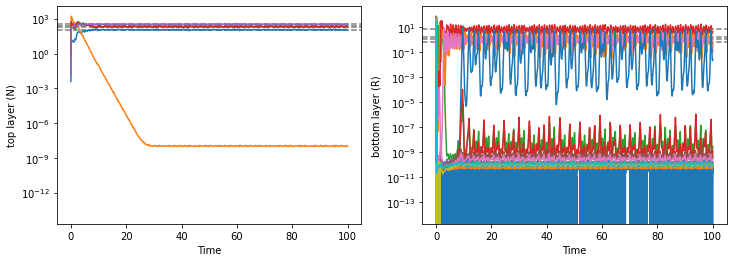

In [364]:
#migration=1e-7
#sol = solve_ivp(asymmetric_consumer_resource, t_span=[0,100], y0=initial_state.copy(), dense_output=True,method='Radau',atol=1e-10,rtol=1e-10)



plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

N_opt=prob.constraints[0].dual_value
for value in N_values:
       plt.axhline(value,color='grey',ls='--')
plt.plot(sol.t, sol.y[:top_species].T)
plt.xlabel('Time')
plt.ylabel('top layer (N)')
plt.yscale('log')

plt.subplot(1,2,2)


for value in R_values:
       plt.axhline(value,color='grey',ls='--')
          
plt.plot(sol.t, sol.y[top_species:].T)
plt.xlabel('Time')
plt.ylabel('bottom layer (R)')
plt.yscale('log')

     


plt.show()

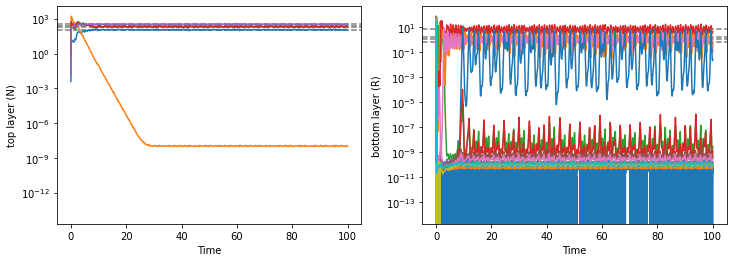

In [365]:
migration=1e-8
sol = solve_ivp(asymmetric_consumer_resource, t_span=[0,100], y0=initial_state.copy(), dense_output=True,method='LSODA',atol=1e-10,rtol=1e-10)



plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

N_opt=prob.constraints[0].dual_value
for value in N_values:
       plt.axhline(value,color='grey',ls='--')
plt.plot(sol.t, sol.y[:top_species].T)
plt.xlabel('Time')
plt.ylabel('top layer (N)')
plt.yscale('log')

plt.subplot(1,2,2)


for value in R_values:
       plt.axhline(value,color='grey',ls='--')
          
plt.plot(sol.t, sol.y[top_species:].T)
plt.xlabel('Time')
plt.ylabel('bottom layer (R)')

plt.yscale('log')
     


plt.show()

# def steady_state(self):
    # Calculate the steady-state of the model
    R_opt = cvx.Variable(len(self.k))
    if self.resource_dynamics == 'MCRM':
        constraints = [self.C @ R_opt <= self.m, R_opt >= 0]
        prob = cvx.Problem(cvx.Minimize(0.5 * cvx.sum_squares(R_opt - self.k)), constraints)
        prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-7, eps_rel=1e-7, max_iter=100000, warm_start=True, verbose=False)
    elif self.resource_dynamics == 'linear':
        constraints = [self.C @ R_opt <= self.m, R_opt >= 0]
        prob = cvx.Problem(cvx.Minimize(cvx.sum(cvx.kl_div(self.k + 1e-9, R_opt + 1e-9))), constraints)
        prob_output = prob.solve(solver=cvx.ECOS, abstol=1e-7, reltol=1e-7, warm_start=True, verbose=False, max_iters=100000)
    return  prob.constraints[0].dual_value, R_opt.value